In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st
from pybaselines import whittaker
from scipy.fft import fft
from statsmodels.regression.linear_model import yule_walker
import heartpy as htp
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')
import pywt
from scipy import ndimage
from datetime import datetime
import time
import neurokit2 as nk


from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## Feature calculation functions

In [18]:
def calc_baseline(signal):
    """
    Calculate the baseline of signal.
    Args:
        signal (numpy 1d array): signal whose baseline should be calculated
    Returns:
        baseline (numpy 1d array with same size as signal): baseline of the signal
    """
    ssds = np.zeros((3))

    cur_lp = np.copy(signal)
    iterations = 0
    while True:
        # Decompose 1 level
        lp, hp = pywt.dwt(cur_lp, "db4")
        if iterations > 250:
            print('r')
            return whittaker.iasls(signal)[0]
        

        # Shift and calculate the energy of detail/high pass coefficient
        ssds = np.concatenate(([np.sum(hp ** 2)], ssds[:-1]))

        # Check if we are in the local minimum of energy function of high-pass signal
        if ssds[2] > ssds[1] and ssds[1] < ssds[0]:
            break

        cur_lp = lp[:]
        iterations += 1

    # Reconstruct the baseline from this level low pass signal up to the original length
    baseline = cur_lp[:]
    for _ in range(iterations):
        baseline = pywt.idwt(baseline, np.zeros((len(baseline))), "db4")

    return baseline[: len(signal)]

def get_gaussian(sigRate=1000, fwhm=1000, k=500):
    gauss_time = np.arange(-k,k)
    # create Gaussian window
    gauswin = np.exp( -(4*np.log(2)*gauss_time**2) / fwhm**2 )

    pstPeakHalf = k + np.argmin( (gauswin[k:]-.5)**2 )
    prePeakHalf = np.argmin((gauswin-.5)**2)
    empFWHM = gauss_time[pstPeakHalf] - gauss_time[prePeakHalf]

    gauss_win = np.exp(-(4*np.log(2)*gauss_time**2) / empFWHM**2 ) 
    return gauss_win / np.sum(gauss_win)


def filt_signal(signal_mx, width, mode='mov_avg'):
    if mode == 'mov_avg':
        return ndimage.convolve(signal_mx, (np.ones(width)/width).reshape(1, -1))
    return ndimage.convolve(signal_mx, get_gaussian(fwhm=width, k=int(width*1.5)).reshape(1, -1))

# def gauss(signal, width):
#     gauss_win = get_gaussian(fwhm=width, k=int(width*1.5))
#     return np.convolve(np.array(signal), gauss_win, mode='valid') 

# def mov_avg(signal, width):
#     return np.convolve(np.array(signal), np.ones(width)/width, mode='valid')

def drift_erasing(signal, mode):
    if mode == 'als':
        return signal - whittaker.iasls(signal)[0]
    return signal - calc_baseline(signal)
    
def gauss_and_als(signal, width):
    gauss_win = get_gaussian(fwhm=width, k=int(width*1.5))
    filt_sig = np.convolve(np.array(signal), gauss_win, mode='valid')
    return filt_sig - whittaker.iasls(filt_sig)[0]

def KTE(x, q=1, s=-1):
    
    iedges = abs(q) + abs(s)
    n = np.arange(iedges + 1, (x.shape[1] - iedges - 1))
    return (x[:, n]**2 - x[:, n-q] * x[:, n-s])

def get_frames(signal, sec_width, inersection=0.5, normalize=True):
    width_in_pts = sec_width * 1000
    pts_to_delete = len(signal) % width_in_pts
    signal = signal[pts_to_delete // 2: len(signal) -pts_to_delete + (pts_to_delete // 2)]
    partition_length = width_in_pts // 2
    first_partition = signal[:partition_length].reshape(-1, partition_length)
    last_partition = signal[-partition_length:].reshape(-1, partition_length)
    signal_core = signal[partition_length:-partition_length].reshape(-1, partition_length)
    shifted_up = np.vstack([first_partition, signal_core])
    shifted_down = np.vstack([signal_core, last_partition])
    frames = np.hstack([shifted_up, shifted_down])
    if normalize:
        return frames / np.sum(frames, axis=1).reshape(len(frames), -1)
    return frames

def calculate_entropy(frames):
    return np.sum(frames * np.log(frames), axis=1)

def get_AR_coeffs_from_mx(signal_matrix):
    ar_coefs = []
    for signal in signal_matrix:
        try:
            ar_coefs.append(yule_walker(signal, order=5)[0])
        except:
            ar_coefs.append([-1]*5)
    return np.array(ar_coefs)
#     return np.array(list(map(lambda x: yule_walker(x, order=5)[0], signal_matrix)))

def get_ar_names(feature, order=5):
    return [f'AR_{feature}_{i + 1}' for i in range(order)]

def get_hr(signal_matrix):
    hr_chars = []
    for signal in signal_matrix:
        try:
            res = list(htp.process(signal, sample_rate = 1000, clean_rr=True, calc_freq=True)[1].values())
            if np.nan in res:
                hr_chars.append([np.nan]*23)
            else:
                hr_chars.append(res)
        except:
            hr_chars.append([np.nan]*23)
    return np.array(hr_chars)

def scale(signal_mx, scaler_nm='minmax'):
    if scaler_nm == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_nm == 'standard':
        scaler = StandardScaler()
    return scaler.fit_transform(signal_mx.T).T

**Model testing**

In [11]:
def get_scaled_encoded_df(df, numeric_features, cat_features, encode=True):
    #MinMaxScaller
    numeric_data = df[numeric_features].applymap(float)
    scaled_numeric_features = (numeric_data - numeric_data.min()) / (numeric_data.max() - numeric_data.min())
    if encode and len(cat_features):
        one_hot = pd.get_dummies(df[cat_features])
        return scaled_numeric_features.join(one_hot)
    else:
        return scaled_numeric_features.join(df[cat_features])

## Pipeline for calculation and writing to new dataframe

In [12]:
def features_calc_to_csv(name_df, signal_name, chunksize, filt_nm, filt_width=30, frame_width=5, drift_nm='', scale_nm='', preprocess=True, get_informative_part=False):
    hr_names = ['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20', 'pnn50', 
                'hr_mad', 'sd1', 'sd2', 's', 'sd1/sd2', 'breathingrate', 'vlf',
                'lf', 'hf', 'lf/hf', 'p_total', 'vlf_perc', 'lf_perc', 'hf_perc', 'lf_nu', 'hf_nu']
    hr_names = list(map(lambda x: x + '_ppg', hr_names))
    df_columns = pd.read_csv(f'{name_df}.csv', nrows=2).columns
    with pd.read_csv(f'{name_df}.csv', chunksize=chunksize) as reader:
        for i, chunk in enumerate(reader):
            chunk.columns = df_columns
            # signal extracting and preprocessing
            chunk[signal_name] = chunk[signal_name].apply(lambda x: np.array(list(map(float, x.strip('][').split(',')))))
            # check for correct length of signal
            chunk = chunk[chunk[signal_name].apply(len) == 180000]
            if preprocess:
                preprocessed_signal = filt_signal(np.array(chunk[signal_name].tolist()), width=filt_width, mode=filt_nm)
                if drift_nm:
                    preprocessed_signal = np.array(list(map(lambda x: drift_erasing(x, mode=drift_nm), preprocessed_signal)))
                if scale_nm:
                    preprocessed_signal = scale(preprocessed_signal, scaler_nm=scale_nm)
            elif filt_nm == 'butter':
                preprocessed_signal = np.array(list(map(lambda x: nk.ppg_process(x, sampling_rate=1000)[0], preprocessed_signal)))
            else:
                preprocessed_signal = np.array(chunk[signal_name].tolist())
#             print(preprocessed_signal.shape)
            if get_informative_part:
                infomative_signal = []
                for signal in preprocessed_signal:
                    frames = get_frames(signal, 60, normalize=False)
                    frames_KTE = KTE(frames)
                    best_frame_num = np.argmax(np.mean(frames_KTE, axis=1))
                    infomative_signal.append(frames[best_frame_num, :])
                preprocessed_signal = np.array(infomative_signal)
            print(preprocessed_signal.shape)
            chunk[get_ar_names('PPG')] = get_AR_coeffs_from_mx(preprocessed_signal)
            chunk.drop(labels=signal_name, axis='columns', inplace=True)
            # calculation of KTE and its characteristics
            KTE_mx = KTE(preprocessed_signal)
            chunk[get_ar_names('KTE')] = get_AR_coeffs_from_mx(KTE_mx)
            chunk['KTE_mean'] = np.mean(KTE_mx, axis=1)
            chunk['KTE_std'] = np.std(KTE_mx, axis=1)
            chunk['KTE_skew'] = st.skew(KTE_mx, axis=1)
            chunk['KTE_iqr'] = st.iqr(KTE_mx, axis=1)
            # calculation of entropy and its characteristics
            entropies = []
            fft_signal = fft(preprocessed_signal)
            squared_abs = np.abs(fft_signal)**2
            for signal in squared_abs:
                frames = get_frames(signal, frame_width)
                entropies.append(calculate_entropy(frames))
            entropies_mx = np.array(entropies)
            chunk['entropy_mean'] = np.mean(entropies_mx, axis=1)
            chunk['entropy_std'] = np.std(entropies_mx, axis=1)
            chunk['entropy_skew'] = st.skew(entropies_mx, axis=1)
            chunk['entropy_iqr'] = st.iqr(entropies_mx, axis=1)
            # calculation of spectral energy and its characteristics
            spectral_energies = []
            for signal in preprocessed_signal:
                frames = get_frames(signal, frame_width, normalize=False)
                spectral_energies.append(np.log(np.sum(frames**2, axis=1)))
            spectral_energies_mx = np.array(spectral_energies)
            chunk[get_ar_names('spectral_energy')] = get_AR_coeffs_from_mx(spectral_energies_mx)
            chunk['spectral_energy_mean'] = np.mean(spectral_energies_mx, axis=1)
            chunk['spectral_energy_std'] = np.std(spectral_energies_mx, axis=1)
            chunk['spectral_energy_skew'] = st.skew(spectral_energies_mx, axis=1)
            chunk['spectral_energy_iqr'] = st.iqr(spectral_energies_mx, axis=1)
            # hr characteristics
            hr_chars = get_hr(preprocessed_signal)
#             print(hr_chars)
            chunk[hr_names] = hr_chars
            if i == 0:
                chunk.to_csv(f'{name_df}_features_calc_{filt_nm}_{filt_width}_{drift_nm}_{scale_nm}.csv', index=False, mode='a')
            else:
                chunk.to_csv(f'{name_df}_features_calc_{filt_nm}_{filt_width}_{drift_nm}_{scale_nm}.csv', header=False, index=False, mode='a')

In [6]:
features_calc_to_csv('unprocessed_dataset', 'ppg_data', 500, 'butter')

(500, 180000)
(498, 180000)
(495, 180000)
(500, 180000)
(500, 180000)
(455, 180000)


In [27]:
features_calc_to_csv('unprocessed_dataset', 'ppg_data', 500, 'mov_avg', drift_nm='als')

(500, 180000)
(498, 180000)
(495, 180000)
(500, 180000)
(500, 180000)
(455, 180000)


In [13]:
features_calc_to_csv('unprocessed_dataset', 'ppg_data', 500, 'gauss', drift_nm='als')

(500, 180000)
(498, 180000)
(495, 180000)
(500, 180000)
(500, 180000)
(455, 180000)


In [14]:
features_calc_to_csv('unprocessed_dataset', 'ppg_data', 500, filt_nm='', drift_nm='als', preprocess=False)

(500, 180000)
(498, 180000)
(495, 180000)
(500, 180000)
(500, 180000)
(455, 180000)


In [25]:
df = pd.read_csv('unprocessed_dataset_features_calc_butter.csv').iloc[:, -50:]

In [35]:
df = pd.read_csv('unprocessed_dataset_features_calc_mov_avg_30_als_nocleanrr.csv').iloc[:, -50:]

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AR_PPG_1              2406 non-null   float64
 1   AR_PPG_2              2406 non-null   float64
 2   AR_PPG_3              2406 non-null   float64
 3   AR_PPG_4              2406 non-null   float64
 4   AR_PPG_5              2406 non-null   float64
 5   AR_KTE_1              2406 non-null   float64
 6   AR_KTE_2              2406 non-null   float64
 7   AR_KTE_3              2406 non-null   float64
 8   AR_KTE_4              2406 non-null   float64
 9   AR_KTE_5              2406 non-null   float64
 10  KTE_mean              2406 non-null   float64
 11  KTE_std               2406 non-null   float64
 12  KTE_skew              2406 non-null   float64
 13  KTE_iqr               2406 non-null   float64
 14  entropy_mean          2406 non-null   float64
 15  entropy_std          

In [7]:
def analyze_filt_width_and_feature_importance(width_range=30, scale_nm='minmax', filt_nm='mov_avg', drift_nm='als', preprocess=True, frame_width=5, chunksize=500, df_name='fasting', get_informative_part=True, to_csv=True):
    for width in width_range:
        if to_csv:
            features_calc_to_csv(df_name, 'ppg_data', chunksize, frame_width=frame_width, filt_nm=filt_nm, filt_width=width, drift_nm=drift_nm, scale_nm=scale_nm, preprocess=preprocess, get_informative_part=get_informative_part)
        df_fasting = pd.read_csv(f'{df_name}_features_calc_{filt_nm}_{width}_{drift_nm}_{scale_nm}.csv').dropna()
        df_fasting = df_fasting[df_fasting['s'].apply(float) != -1]
        cols_to_drop = ['cid', 'Наличие диабета', 'Уровень глюкозы, ммоль/л', 'Возраст, лет', 'Вес, кг', 'Рост, см', 'Пол']
        cat_features = []
        y_fasting = df_fasting['Уровень глюкозы, ммоль/л']
        df_fasting_core = df_fasting.drop(labels=cols_to_drop, axis='columns')
        numeric_features =  list(set(df_fasting_core.columns).difference(set(cat_features)))
        fasting_encoded = get_scaled_encoded_df(df_fasting_core, numeric_features, cat_features)
        print(f'Window width: {width}')
        print(f'Non null object count: {len(fasting_encoded)}')
        print(-cross_val_score(XGBRegressor(), fasting_encoded, y_fasting, scoring='neg_root_mean_squared_error', cv=5).mean())

In [41]:
for width in range(1000, 1100, 100):
    features_calc_to_csv('fasting', 'ppg_data', 500, filt=mov_avg, filt_width=width)
    df_fasting = pd.read_csv(f'fasting_features_calc_{width}.csv').dropna()
    df_fasting = df_fasting[df_fasting['s'].apply(float) != -1]
    cols_to_drop = ['cid', 'Наличие диабета', 'Уровень глюкозы, ммоль/л']
    cat_features = ['Пол']
    y_fasting = df_fasting['Уровень глюкозы, ммоль/л']
    df_fasting_core = df_fasting.drop(labels=cols_to_drop, axis='columns')
    numeric_features =  list(set(df_fasting_core.columns).difference(set(cat_features)))
    fasting_encoded = get_scaled_encoded_df(df_fasting_core, numeric_features, cat_features)
    print(f'Window width: {width}')
    print(f'Non null object count: {len(fasting_encoded)}')
    greedy_selection(fasting_encoded, y_fasting, SVR())
    print(-cross_val_score(XGBRegressor(), fasting_encoded, y_fasting, scoring='neg_root_mean_squared_error', cv=5).mean())

(498, 179001)
0
(137, 179001)
Window width: 1000
Non null object count: 51
SVR, features: ['Вес, кг', 'entropy_skew', 'Возраст, лет'], rmse: 2.074534270346322
2.068240207100173


In [49]:
for width in range(25, 45, 5):
    features_calc_to_csv('fasting', 'ppg_data', 500, filt=mov_avg, filt_nm='mov_avg', filt_width=width)
    df_fasting = pd.read_csv(f'fasting_features_calc_mov_avg_{width}.csv').dropna()
    df_fasting = df_fasting[df_fasting['s'].apply(float) != -1]
    cols_to_drop = ['cid', 'Наличие диабета', 'Уровень глюкозы, ммоль/л']
    cat_features = ['Пол']
    y_fasting = df_fasting['Уровень глюкозы, ммоль/л']
    df_fasting_core = df_fasting.drop(labels=cols_to_drop, axis='columns')
    numeric_features =  list(set(df_fasting_core.columns).difference(set(cat_features)))
    fasting_encoded = get_scaled_encoded_df(df_fasting_core, numeric_features, cat_features)
    print(f'Window width: {width}')
    print(f'Non null object count: {len(fasting_encoded)}')
    greedy_selection(fasting_encoded, y_fasting, SVR())
    print(-cross_val_score(XGBRegressor(), fasting_encoded, y_fasting, scoring='neg_root_mean_squared_error', cv=5).mean())

(498, 179976)
0
(137, 179976)
Window width: 25
Non null object count: 479
SVR, features: ['Вес, кг', 'sd2', 'AR_KTE_4', 'AR_KTE_2', 'Возраст, лет'], rmse: 2.476594095412856
2.9000258780546417
(498, 179971)
0
(137, 179971)
Window width: 30
Non null object count: 481
SVR, features: ['Вес, кг', 'Рост, см', 'Возраст, лет', 'AR_KTE_4', 'AR_KTE_2', 'AR_PPG_1', 'sd2'], rmse: 2.4539591830413143
2.6493806502655204
(498, 179966)
0
(137, 179966)
Window width: 35
Non null object count: 479
SVR, features: ['Вес, кг', 'Рост, см', 'Возраст, лет', 'sdnn', 'AR_PPG_4'], rmse: 2.5549269200939326
2.640558613677411
(498, 179961)
0
(137, 179961)
Window width: 40
Non null object count: 478
SVR, features: ['Вес, кг', 'Рост, см', 'Возраст, лет', 'AR_KTE_2', 'AR_KTE_4', 'sd2'], rmse: 2.479332992662171
2.6787697812922824


In [23]:
analyze_filt_width_and_feature_importance([30], filt_nm='', scale_nm='', preprocess=False)

498
137
Window width: 30
Non null object count: 250
SVR, features: ['AR_PPG_5', 'AR_spectral_energy_5'], rmse: 2.8647163906283337
3.4274132478515553


In [33]:
analyze_filt_width_and_feature_importance([30], filt_nm='mov_avg', scale_nm='', frame_width=2)

498
137
Window width: 30
Non null object count: 468
SVR, features: ['sd2', 'AR_KTE_5', 'sdnn', 'KTE_iqr', 'AR_PPG_2', 'AR_PPG_3'], rmse: 2.807616663412107
2.944139905163722


In [56]:
# 1min
analyze_filt_width_and_feature_importance([30], filt_nm='mov_avg', scale_nm='')

498
137
Window width: 30
Non null object count: 548
SVR, features: ['hr_mad', 'entropy_mean', 'AR_KTE_5', 'KTE_mean', 'AR_spectral_energy_2'], rmse: 2.886670958318034
3.058857489444013


In [31]:
analyze_filt_width_and_feature_importance([30], filt_nm='mov_avg', scale_nm='')

498
137
Window width: 30
Non null object count: 468
SVR, features: ['sd2', 'AR_KTE_5', 'sdnn', 'entropy_mean'], rmse: 2.8087661416508545
2.863582440075263


In [30]:
analyze_filt_width_and_feature_importance([30], filt_nm='mov_avg', scale_nm='', frame_width=10)

498
137
Window width: 30
Non null object count: 468
SVR, features: ['sd2', 'AR_KTE_5', 'sdnn', 'KTE_iqr', 'AR_PPG_2', 'AR_PPG_3'], rmse: 2.807616663412107
3.087988231063753


In [57]:
analyze_filt_width_and_feature_importance([30], filt_nm='mov_avg', scale_nm='als')

498
137
Window width: 30
Non null object count: 619
SVR, features: ['pnn20', 'entropy_skew', 'spectral_energy_skew'], rmse: 2.9424608463754236
3.137705387993901


In [21]:
# 1 min
analyze_filt_width_and_feature_importance([30], filt_nm='mov_avg', scale_nm='als', frame_width=5, get_informative_part=True)

498
137
Window width: 30
Non null object count: 624
SVR, features: ['sd2', 'KTE_skew', 'sd1/sd2'], rmse: 2.9411131434154276
3.0408652184577027


In [50]:
for width in range(25, 40, 5):
    features_calc_to_csv('fasting', 'ppg_data', 500, filt=gauss, filt_nm='gauss', filt_width=width)
    df_fasting = pd.read_csv(f'fasting_features_calc_gauss_{width}.csv').dropna()
    df_fasting = df_fasting[df_fasting['s'].apply(float) != -1]
    cols_to_drop = ['cid', 'Наличие диабета', 'Уровень глюкозы, ммоль/л', 'Возраст, лет', 'Вес, кг', 'Рост, см', 'Пол']
    cat_features = []
    y_fasting = df_fasting['Уровень глюкозы, ммоль/л']
    df_fasting_core = df_fasting.drop(labels=cols_to_drop, axis='columns')
    numeric_features =  list(set(df_fasting_core.columns).difference(set(cat_features)))
    fasting_encoded = get_scaled_encoded_df(df_fasting_core, numeric_features, cat_features)
    print(f'Window width: {width}')
    print(f'Non null object count: {len(fasting_encoded)}')
    greedy_selection(fasting_encoded, y_fasting, SVR())
    print(-cross_val_score(XGBRegressor(), fasting_encoded, y_fasting, scoring='neg_root_mean_squared_error', cv=5).mean())

(498, 179927)
0
(137, 179927)
Window width: 25
Non null object count: 470
SVR, features: ['Вес, кг', 'Рост, см', 'Возраст, лет', 'AR_KTE_4', 'KTE_std', 'AR_KTE_5'], rmse: 2.5630304507254795
2.6731875541101453
(498, 179911)
0
(137, 179911)
Window width: 30
Non null object count: 469
SVR, features: ['Вес, кг', 'sd2', 'Возраст, лет', 'Рост, см'], rmse: 2.5913716718867184
2.6580401325112892
(498, 179897)
0
(137, 179897)
Window width: 35
Non null object count: 464
SVR, features: ['Вес, кг', 'Возраст, лет', 'AR_KTE_4', 'KTE_iqr', 'AR_KTE_5', 'pnn20', 'sd1/sd2', 'KTE_std', 'AR_PPG_4', 'AR_PPG_3', 'AR_PPG_2'], rmse: 2.484548889369358
2.6108697530290264


In [52]:
for width in range(30, 40, 5):
    features_calc_to_csv('fasting', 'ppg_data', 500, filt=gauss_and_als, filt_nm='gauss_als', filt_width=width)
    df_fasting = pd.read_csv(f'fasting_features_calc_gauss_als_{width}.csv').dropna()
    df_fasting = df_fasting[df_fasting['s'].apply(float) != -1]
    cols_to_drop = ['cid', 'Наличие диабета', 'Уровень глюкозы, ммоль/л']
    cat_features = ['Пол']
    y_fasting = df_fasting['Уровень глюкозы, ммоль/л']
    df_fasting_core = df_fasting.drop(labels=cols_to_drop, axis='columns')
    numeric_features =  list(set(df_fasting_core.columns).difference(set(cat_features)))
    fasting_encoded = get_scaled_encoded_df(df_fasting_core, numeric_features, cat_features)
    print(f'Window width: {width}')
    print(f'Non null object count: {len(fasting_encoded)}')
    greedy_selection(fasting_encoded, y_fasting, SVR())
    print(-cross_val_score(XGBRegressor(), fasting_encoded, y_fasting, scoring='neg_root_mean_squared_error', cv=5).mean())

(498, 179911)
0
(137, 179911)
Window width: 30
Non null object count: 623
SVR, features: ['Вес, кг', 'Рост, см', 'pnn20', 'AR_KTE_4', 'Возраст, лет', 'spectral_energy_mean', 'AR_spectral_energy_5'], rmse: 2.6041305075401415
2.7823195036632056
(498, 179897)
0
(137, 179897)
Window width: 35
Non null object count: 622
SVR, features: ['Вес, кг', 'hr_mad', 'spectral_energy_iqr'], rmse: 2.635924536020073
2.721458387690839


In [95]:
for width in range(30, 35, 5):
    features_calc_to_csv('fasting', 'ppg_data', 500, filt=mov_avg_mx, filt_nm='mov_avg_mx', filt_width=width)
    df_fasting = pd.read_csv(f'fasting_features_calc_mov_avg_{width}.csv').dropna()
    df_fasting = df_fasting[df_fasting['s'].apply(float) != -1]
    cols_to_drop = ['cid', 'Наличие диабета', 'Уровень глюкозы, ммоль/л']
    cat_features = ['Пол']
    y_fasting = df_fasting['Уровень глюкозы, ммоль/л']
    df_fasting_core = df_fasting.drop(labels=cols_to_drop, axis='columns')
    numeric_features =  list(set(df_fasting_core.columns).difference(set(cat_features)))
    fasting_encoded = get_scaled_encoded_df(df_fasting_core, numeric_features, cat_features)
    print(f'Window width: {width}')
    print(f'Non null object count: {len(fasting_encoded)}')
    greedy_selection(fasting_encoded, y_fasting, SVR())
    print(-cross_val_score(XGBRegressor(), fasting_encoded, y_fasting, scoring='neg_root_mean_squared_error', cv=5).mean())

(498, 180000)
0
(137, 180000)
Window width: 30
Non null object count: 481
SVR, features: ['Вес, кг', 'Рост, см', 'Возраст, лет', 'AR_KTE_4', 'AR_KTE_2', 'AR_PPG_1', 'sd2'], rmse: 2.4539591830413143
2.6493806502655204


In [11]:
for width in range(30, 35, 5):
    features_calc_to_csv('fasting', 'ppg_data', 50, filt_nm='mov_avg', filt_width=width, scale_nm='wavelet')
    df_fasting = pd.read_csv(f'fasting_features_calc_mov_avg_{width}_wavelet.csv').dropna()
    df_fasting = df_fasting[df_fasting['s'].apply(float) != -1]
    cols_to_drop = ['cid', 'Наличие диабета', 'Уровень глюкозы, ммоль/л']
    cat_features = ['Пол']
    y_fasting = df_fasting['Уровень глюкозы, ммоль/л']
    df_fasting_core = df_fasting.drop(labels=cols_to_drop, axis='columns')
    numeric_features =  list(set(df_fasting_core.columns).difference(set(cat_features)))
    fasting_encoded = get_scaled_encoded_df(df_fasting_core, numeric_features, cat_features)
    print(f'Window width: {width}')
    print(f'Non null object count: {len(fasting_encoded)}')
    greedy_selection(fasting_encoded, y_fasting, SVR())
    print(-cross_val_score(XGBRegressor(), fasting_encoded, y_fasting, scoring='neg_root_mean_squared_error', cv=5).mean())

50
100
r
150
200
r
250
300
350
400
r
450
r
500
550
600
650
Window width: 30
Non null object count: 566
SVR, features: ['Вес, кг', 'Рост, см'], rmse: 2.728494259147001
2.876616084798618


In [12]:
for width in range(30, 35, 5):
    features_calc_to_csv('fasting', 'ppg_data', 200, filt_nm='mov_avg', filt_width=width, scale_nm='als')
    df_fasting = pd.read_csv(f'fasting_features_calc_mov_avg_{width}_als.csv').dropna()
    df_fasting = df_fasting[df_fasting['s'].apply(float) != -1]
    cols_to_drop = ['cid', 'Наличие диабета', 'Уровень глюкозы, ммоль/л']
    cat_features = ['Пол']
    y_fasting = df_fasting['Уровень глюкозы, ммоль/л']
    df_fasting_core = df_fasting.drop(labels=cols_to_drop, axis='columns')
    numeric_features =  list(set(df_fasting_core.columns).difference(set(cat_features)))
    fasting_encoded = get_scaled_encoded_df(df_fasting_core, numeric_features, cat_features)
    print(f'Window width: {width}')
    print(f'Non null object count: {len(fasting_encoded)}')
    greedy_selection(fasting_encoded, y_fasting, SVR())
    print(-cross_val_score(XGBRegressor(), fasting_encoded, y_fasting, scoring='neg_root_mean_squared_error', cv=5).mean())

200
400
600
800
Window width: 30
Non null object count: 623
SVR, features: ['Вес, кг', 'Рост, см', 'pnn20', 'Возраст, лет', 'spectral_energy_iqr', 'AR_PPG_5', 'AR_KTE_4', 'AR_KTE_2'], rmse: 2.6057357103706504
2.8094051402575935


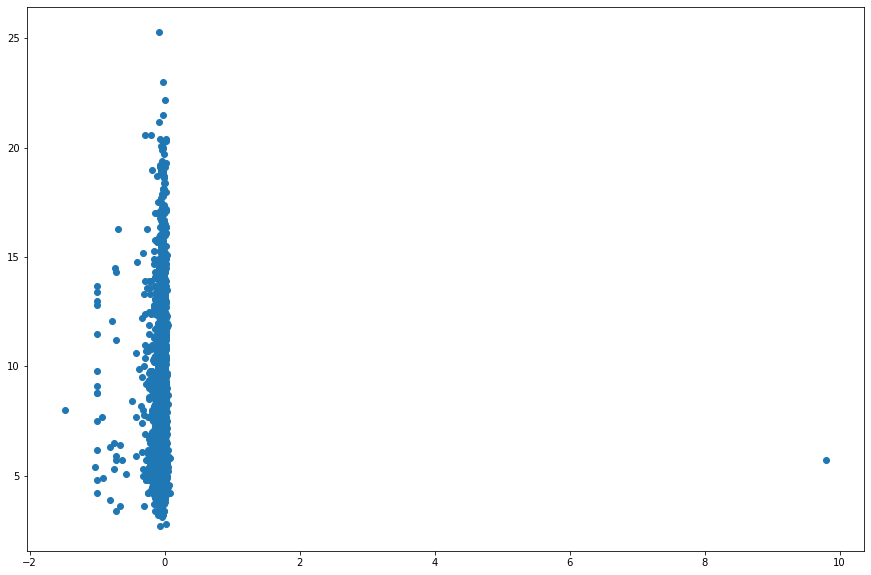

In [30]:
plt.figure(figsize=(15, 10))
plt.scatter(df['AR_KTE_4'], pd.read_csv('unprocessed_dataset_features_calc_butter.csv')['Уровень глюкозы, ммоль/л'])

In [107]:
analyze_filt_width_and_feature_importance([30], chunksize=400, scale_nm='standard', df_name='food')

(400, 60000)
(399, 60000)
(395, 60000)
(400, 60000)
(400, 60000)
(173, 60000)
Window width: 30
Non null object count: 2146
3.6014128720655854


**Method's visualizations**

bpm: 77.619664
ibi: 773.000000
sdnn: 19.752637
sdsd: 14.364212
rmssd: 28.675298
pnn20: 0.363636
pnn50: 0.000000
hr_mad: 12.000000
sd1: 20.264165
sd2: 19.336302
s: 1230.982810
sd1/sd2: 1.047986
breathingrate: 0.215610
vlf: 0.000000
lf: 0.000000
hf: 58.481680
lf/hf: 0.000000
p_total: 58.481680
vlf_perc: 0.000000
lf_perc: 0.000000
hf_perc: 100.000000
lf_nu: 0.000000
hf_nu: 100.000000


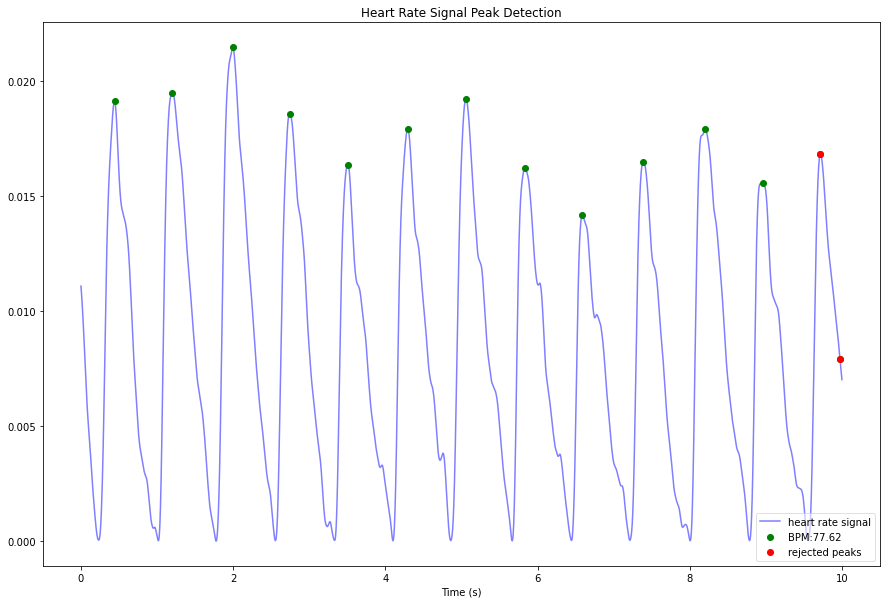

In [33]:
#set large figure
preprocessed_signal = np.array(df_fasting['ppg_data'].apply(lambda x: gauss_and_als(x, 30)).tolist())
wd, m = htp.process(preprocessed_signal[2][:10000], sample_rate = 1000, clean_rr=True, calc_freq=True)


#call plotter
# plt.figure(figsize=(20, 20))
htp.plotter(wd, m, figsize=(15, 10))

#display measures computed
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

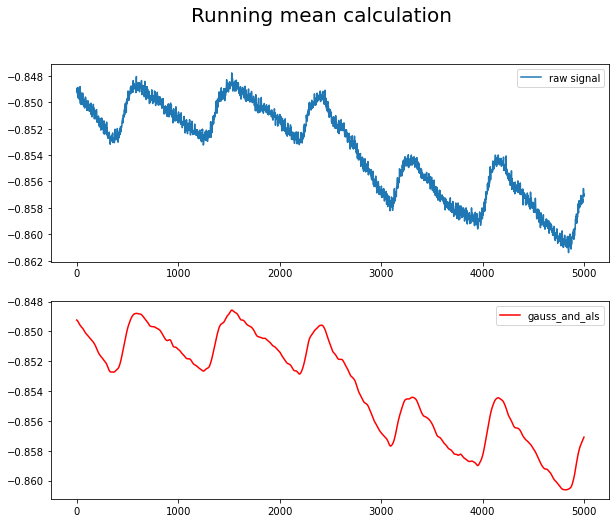

In [39]:
res = filt_signal(np.array(df_fasting['ppg_data'].tolist()), width=30)[3]
fig = plt.figure( figsize=(10, 8))
fig.suptitle('Running mean calculation', fontsize=20)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax1.plot(df_fasting['ppg_data'][3][:5000], label='raw signal')
ax2.plot(res[:5000], color='r', label='gauss_and_als')
ax1.legend()
ax2.legend()

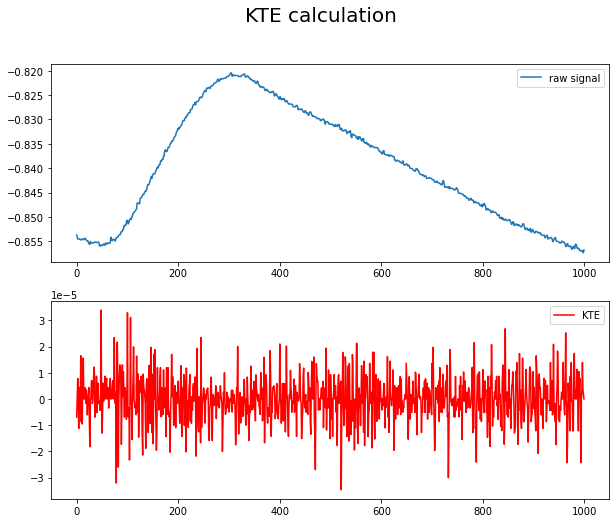

In [105]:
res = KTE(mov_avg_mx(np.array(df_fasting['ppg_data'].tolist()), width=30))[0]
fig = plt.figure( figsize=(10, 8))
fig.suptitle('KTE calculation', fontsize=20)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax1.plot(df_fasting['ppg_data'][0][500:1500], label='raw signal')
ax2.plot(res[500:1500], color='r', label='KTE')
ax1.legend()
ax2.legend()

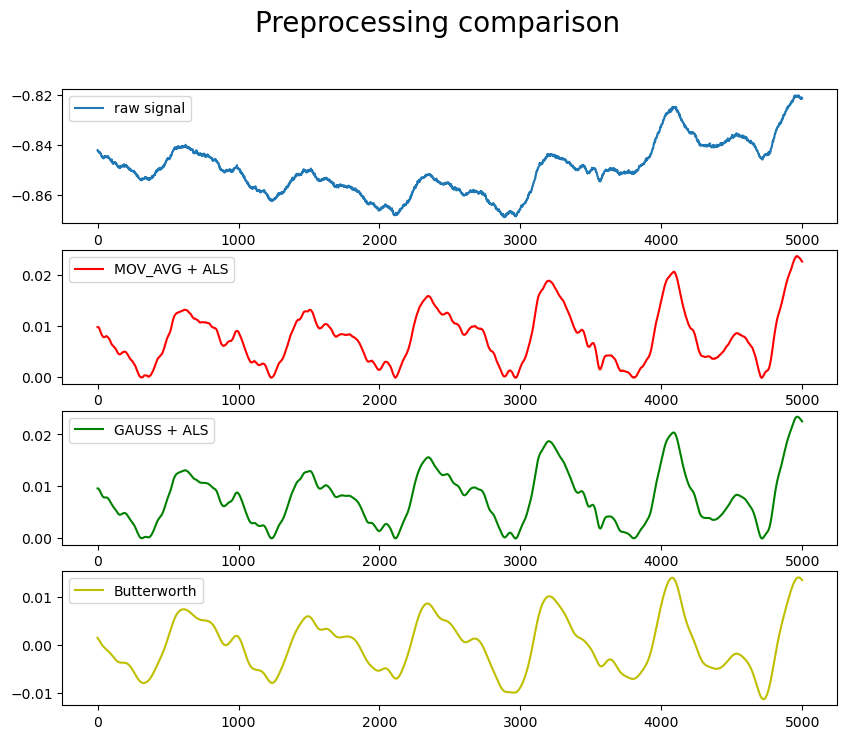

In [26]:
df_fasting = pd.read_csv('unprocessed_dataset.csv', nrows=5)
df_fasting['ppg_data'] = df_fasting['ppg_data'].apply(lambda x: np.array(list(map(float, x.strip('][').split(',')))))
signal_mov_avg = filt_signal(np.array(df_fasting['ppg_data'].tolist()), width=30, mode='mov_avg')[4]
signal_gauss = filt_signal(np.array(df_fasting['ppg_data'].tolist()), width=30, mode='gauss')[4]
res_mov_als = signal_mov_avg - whittaker.iasls(signal_mov_avg)[0]
res_gauss_als = signal_gauss - whittaker.iasls(signal_gauss)[0]
signal_butter, info = nk.ppg_process(np.array(df_fasting['ppg_data'].tolist())[4], sampling_rate=1000)
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Preprocessing comparison', fontsize=20)
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2, sharex=ax1)
ax3 = fig.add_subplot(4, 1, 3, sharex=ax1)
ax4 = fig.add_subplot(4, 1, 4, sharex=ax1)
ax1.plot(np.array(df_fasting['ppg_data'].tolist())[4, :5000], label='raw signal')
ax2.plot(res_mov_als[:5000], color='r', label='MOV_AVG + ALS')
ax3.plot(res_gauss_als[:5000], color='g', label='GAUSS + ALS')
ax4.plot(signal_butter['PPG_Clean'][:5000], color='y', label='Butterworth')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

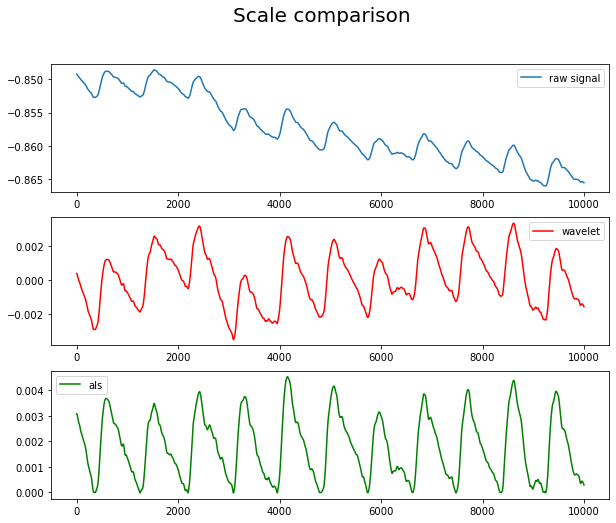

In [4]:
signal = filt_signal(np.array(df_fasting['ppg_data'].tolist()), width=30)[3]
baseline = calc_baseline(signal)
res = signal - baseline
res_als = signal - whittaker.iasls(signal)[0]
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Scale comparison', fontsize=20)
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2, sharex=ax1)
ax3 = fig.add_subplot(3, 1, 3, sharex=ax1)
ax1.plot(signal[:10000], label='raw signal')
ax2.plot(res[:10000], color='r', label='wavelet')
ax3.plot(res_als[:10000], color='g', label='als')
ax1.legend()
ax2.legend()
ax3.legend()